# An Introduction to Neural Networks: Learning the Dubins car dynamics

##### Machine Learning for Systems and Control (SC42165) - TU Delft

In this notebook, we aim to **learn the dynamics of the Dubins car using a fully connected neural network** in Python. For this, we will employ the Pytorch library, which is an optimized tensor library for deep learning using GPUs and CPUs (https://pytorch.org/). 

Let $h$ be a step size, $v$ a velocity, and $u$ a constant control. The Dubins car model (in discrete time) can be described as:

\begin{equation}
x_{t+1} = f(x_t) = \begin{bmatrix}
                      x_{t}^{(1)} + h v \sin(x_{t}^{(3)}) \\
                      x_{t}^{(2)} + h v \cos(x_{t}^{(3)}) \\
                      x_{t}^{(3)} + h u
                    \end{bmatrix}
\end{equation}

where $x_{t}^{(1)}$ represents the $x$-position of the car at instant $t$, $x_{t}^{(2)}$ the $y$-position, and $x_{t}^{(3)}$ is its steering angle. Note that this dynamics is non-linear.

### 1) What we want to see

- **Understand the first sections**: The first 6 sections contain explanations about the dataset and the construction of a simple neural network (NN). There are <span style="color: #8080ff">some questions in blue</span> to guide your understanding (no need to answer them here, but we can discuss them in class or office hours)

- **Code Sections 7 and 8**: Sections 7 and 8 are the main tasks of this exercise. It requires the construction of a larger NN, also varying training choices, as well as building a residual neural network 

- You can do everything on your laptop, but it might be a good idea to use google colab (https://colab.research.google.com/) to get free access to a GPU

- You will send your notebook containing the results (WE WON'T RUN YOUR NOTEBOOK) as a unique jupyter notebook file (.ipynb extension)

### 2) Loading required libraries

First, we load the packages we want to use. This includes Numpy for preprocessing the data, Pytorch (torch) for building and training the neural networks, and Matplotlib for visualization.

In [24]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

### 3) Loading the dataset

To build our dataset, we selected the values for the parameters $h = 0.3$, $v = 5$, and $u = 2$ and generated a dataset $\mathcal{D} = \{ x_{t}, x_{t+1}  \}_{t=0}^{N}$ by simulating the system for multiple (randomly selected) initial positions for 20 time steps. In order words, we use the following routine to build the set:

For $M$ runs:

- Select randomly $x_0$ according to some probability distribution

- Use equation (1) for $H$ steps (we use $H = 20$ in this exercise)

- Store the trajectory as $\{ (x_{0}, x_{1}), ..., (x_{H-1}, x_{H}) \}$

- Include the trajectory in the dataset $\mathcal{D}$


In the end, our dataset $\mathcal{D}$ will contain $MH$ data pairs $(x_{t}, x_{t+1})$, which we will further denote by $(x, y)$ (see, for instance, the dataset columns' names).

For more details, we have also made available the notebook *dataset_generation.ipynb*.

In [25]:
import pandas as pd

#Read CSV file containing data
data = pd.read_csv('data.csv') # change path if necessary

#Deserialize the strings back into NumPy arrays
data['x'] = data['x'].apply(lambda x: np.array(x.split(), dtype=float))
data['y'] = data['y'].apply(lambda x: np.array(x.split(), dtype=float))

Below, we display the first observations of the dataset. Note how each value can be represented by a vector in $\mathbb{R}^3$.

In [26]:
#Display dataset (5 first observations)
data.head(5)

,x,y
0,"[0.3101802085903067, -2.7617156216425283, -0.9...","[-0.8985558258519621, -1.873482994995219, -0.3..."
1,"[1.2107662316485737, -0.518452332717056, -2.02...","[-0.13627455041796743, -1.1783622746406195, -1..."
2,"[-1.8964583531063366, -2.3254043134674305, -2....","[-2.708374788860225, -3.586670225697164, -1.96..."
3,"[-2.5967448061008858, -2.726547485741719, 0.68...","[-1.6451114237123, -1.5670674705954208, 1.2872..."
4,"[-2.4125823366086436, 2.487834736931684, -1.95...","[-3.8019700085300654, 1.9225012980544394, -1.3..."


#### 3.1) Splitting the dataset into training and testing sets

With the help of the Scikit-Learn package (https://scikit-learn.org/stable/) - one of the most famous and useful ML libraries available -, we use the *train_test_split* method to split our dataset in two: 80% of the observations (randomly selected) are included in the training set (used to calibrate the weights of the NN), while the remaining 20% become part of the testing set (used to measure the accuracy of the model on unseen data). Those proportions can be modified by changing the parameter *test_size*.

In [27]:
from sklearn.model_selection import train_test_split

#Splits dataset randomly into testing (20% of observations) and training (80%)
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 0)

#TRAINING
x_train = train_set['x']
y_train = train_set['y']

#TESTING
x_test = test_set['x']
y_test = test_set['y']

We convert the training and testing sets to Pytorch tensors, which is the data structure handle by Pytorch for NN training.

In [28]:
tensor_list = x_train.apply(lambda x: torch.tensor(x)).tolist()
x_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_train.apply(lambda x: torch.tensor(x)).tolist()
y_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = x_test.apply(lambda x: torch.tensor(x)).tolist()
x_test = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_test.apply(lambda x: torch.tensor(x)).tolist()
y_test = torch.stack(tensor_list).to(dtype=torch.float32)

We can check the shape (dimensions) of the tensors as below. 

<span style="color: #8080ff">**QUESTION 1**: </span> What does each dimension of the tensors mean/represent?

The $\mathbf{x}_{\text{train}}$ shape is $[160000, 3]$. The $160000$ are data points for the three states $\mathbf{x}_t = [x_t^{(1)}, x_t^{(2)}, x_t^{(3)}]$.

The $\mathbf{y}_{\text{train}}$ shape is also $[160000, 3]$, but this time for the next states $\mathbf{x}_{t+1} = [x_{t+1}^{(1)}, x_{t+1}^{(2)}, x_{t+1}^{(3)}]$.


In [29]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: torch.Size([160000, 3])
x_test shape: torch.Size([40000, 3])
y_train shape: torch.Size([160000, 3])
y_test shape: torch.Size([40000, 3])
160000 train samples
40000 test samples


### 4) Building our first (simple and small) neural network
The goal is now to create a **dense feedforward neural network** (hereafter denoted by $f_{\text{NN}}$) which can represent the Dubins car dynamics. In other words, we would like that, for any input $x \in \mathbb{R}^3$, $f_{\text{NN}}(w, x) \approx f(x)$ (where $w$ represents the weights of the NN).

<br>
Such network consists out of three parts, which are the <span style="color: #ff8080">input layer</span>, the <span style="color: #8080ff">hidden layers</span> and the <span style="color: #80ff80">output layer</span> (as illustrated by the image below).

![An examplar structure of a feed-forward neural network](Neural_Network.png)


<span style="color: #8080ff">**QUESTION 2**: </span> In our case, how many neurons should the input layer have? How about the output layer? How about the hidden layers, are there any restrictions on the number of neurons?

Since we want to find a function that maps the $\mathbf{x}_t$ states to the $\mathbf{x}_{t+1}$ states and both have three components (states), we need **3 neurons for the input layer** and **3 neurons for the output layer**.

For the hidden layer(s), there are **no strict restrictions** on the number of neurons. Because the input and output sizes are small ($3$), it is wise to make the hidden layers **larger** than the input and output layers. This gives the model more **capacity** to learn the non-linear dynamics of the system.

<span style="color: #8080ff">**QUESTION 3**: </span> We mentioned that we are going to build a dense feedforward NN. What does *feedforward* mean (you can explain this by giving an example of a structure that is not feedforward)? What does *dense* mean? 

Feedforward in the neural networks context means that the information (inputs) only gets forwarded and moves in one direction; it is not looped back into the network. So we have layer 1, layer 2, into layer N, leading to the output.

A non-feedforward example would be a Recurrent Neural Network (RNN), in which the output is fed back into itself or a preceding layer to create a loop.

Dense is defined by the connectivity of nodes in the network. A layer is dense if the connection between it and the preceding layer is high, meaning every node is dependent on every other node from the prior layer, which is defined by maximum connectivity.

In the Pytorch framework, we build the NN as a class, as seen below.

In [30]:
class Neural_network(nn.Module): # inherit the nn.Module class for backpropagation and training functionalities
    
    #Build the layers of the network, and initializes the parameters
    def __init__(self): 
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(3, 10, bias = True)  # fully connected layer from 3 to 10 dimensions
        self.fc2 = nn.Linear(10, 3, bias = True) # fully connected layer from 10 to 3 dimensions
    
    #Build the forward call 
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1) # x is reshaped into a n x 3 dimensional input (actually not needed in our case, but usually useful)
        x = self.fc1(x) # apply the first fully connected layer, x now has shape n x 10
        x = F.relu(x) # apply a ReLU activation to the hidden layer
        x = self.fc2(x) # apply the second fully connected layer, x now has shape n x 3
        return x

The parts of the model, as well as their respective parameters, can then be displayed:

In [31]:
torch.manual_seed(0) # set random seed for variable initialization

net = Neural_network() # initialize the NN
print(net)
print('')

params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')

for param in params:
    print(param.shape)

Neural_network(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

Number of parameter arrays: 4
The shape of the parameter arrays:
torch.Size([10, 3])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


#### 4.1) Training the model
After writing the model class, we can now train the parameters of the model on the training dataset. Here, we have to do a number of steps. 

##### 4.1.1) Defining the loss function

The loss function captures the distance between an actual output and the predicted output by the neural network. In our case, we are in a regression setting, and we propose to use the MSE loss (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). More precisely, given a dataset $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^{N}$, we define 

\begin{equation}
L(w; \mathcal{D}) := \frac{1}{N} \sum_{i=1}^{N} ||y_i - f_{\text{NN}}(w, x_i)||^{2}
\end{equation}

In [32]:
loss_func = nn.MSELoss()

##### 4.1.2) Defining the optimizer

Gradient descent is usually the optimization technique used to minimize the loss. Once we have computed the gradient of the loss $L$ with respect to the weights $w$, there are several ways in which we can update $w$. Pytorch offers several optimizer algorithms for such a task  (https://pytorch.org/docs/stable/optim.html): Adadelta, Adagrad, Adam, etc. 

This paper (https://arxiv.org/pdf/1412.6980.pdf) introduces the Adam algorithm, which we employ in this notebook.

In [33]:
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas = (0.9, 0.999))

##### 4.1.3) Training routine

We describe the training routine as follows:

- Subdivide the training set in (randomly selected) batches of size *batch_size*. The batch $k$ will be represented by $\mathcal{B}_{k} = \{ (x_i, y_i) \}_{i=1}^{B}$, and contains $B$ randomly selected samples from $\mathcal{D}$.

- For each batch $\mathcal{B}_{k}$, compute the gradient of the loss $L(w; \mathcal{B}_{k})$ with respect to $w$. Note that we are considering the loss on the batch $\mathcal{B}_{k}$, and not on the whole training set $\mathcal{D}$.

    - Update the weights $w$ according to the rule defined by the optimizer. You can think of this step as some kind of weight update $w \gets w - \eta \nabla_{w} L(w; \mathcal{B}_{k})$.



Note that this process is repeated for a number of epochs, which is just a fancy name for number of times that we pass through the entire dataset.

In [ ]:
epochs = 100 # how many times we want to go through the whole data set
batch_size = 16 # how many samples do we process before updating weights
batches = int(np.floor(len(y_train)/batch_size)) # how many batches are there when dividing the whole data set

net.train() # set network to training mode
Index = np.arange(len(y_train)) #Index, so we can randomly shuffle inputs and outputs

np.random.seed(0) # set random seed for shuffling

loss_per_epoch = []

for epoch in range(1, epochs + 1):
    np.random.shuffle(Index) # shuffle indices, so batches have randomly selected samples
    
    loss_epoch = 0
    
    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = x_train[Index_batch] # Get respective input data
        y_batch = y_train[Index_batch] # Get respective output data
        
        # delete gradients from optimizer (otherwise, gradients are cummulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(x_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()
        
        loss_epoch += loss
    
    loss_epoch /= batches
    
    loss_per_epoch.append(loss_epoch.item())
    print('Loss for epoch {}/{}: {:0.4e}'.format(epoch, epochs, loss_epoch) )    

Loss for epoch 1/100: 4.3717e-01
Loss for epoch 2/100: 4.2317e-01
Loss for epoch 3/100: 4.1040e-01
Loss for epoch 4/100: 3.9878e-01
Loss for epoch 5/100: 3.6310e-01
Loss for epoch 6/100: 3.2189e-01
Loss for epoch 7/100: 3.0941e-01
Loss for epoch 8/100: 2.9987e-01
Loss for epoch 9/100: 2.9403e-01
Loss for epoch 10/100: 2.9067e-01
Loss for epoch 11/100: 2.8768e-01
Loss for epoch 12/100: 2.8563e-01
Loss for epoch 13/100: 2.8356e-01
Loss for epoch 14/100: 2.8160e-01
Loss for epoch 15/100: 2.8006e-01
Loss for epoch 16/100: 2.7888e-01
Loss for epoch 17/100: 2.7715e-01
Loss for epoch 18/100: 2.7529e-01
Loss for epoch 19/100: 2.7387e-01
Loss for epoch 20/100: 2.7232e-01
Loss for epoch 21/100: 2.7093e-01
Loss for epoch 22/100: 2.6953e-01
Loss for epoch 23/100: 2.6796e-01
Loss for epoch 24/100: 2.6619e-01
Loss for epoch 25/100: 2.6420e-01
Loss for epoch 26/100: 2.6092e-01
Loss for epoch 27/100: 2.2197e-01
Loss for epoch 28/100: 1.2640e-01
Loss for epoch 29/100: 9.9398e-02
Loss for epoch 30/100: 

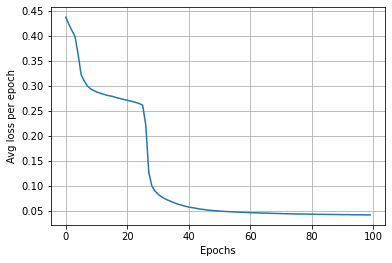

In [43]:
plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Avg loss per epoch')
plt.grid()
plt.show()


<span style="color: #8080ff">**QUESTION 4**: </span> What you observe in the training loss per epoch curve above?

The model is succesfully being trained, the avg loss per epoch is going down as the number of epochs increase. This is exactly the desired trend. Also the slope of the curse is still quite steep at the end of the iteration, conluding epochs could be increased, since the decrease is still more or less linear.


### 5) Testing the model
Finally, the model has to be tested in the testing set (data that was not seen during the training phase):

In [44]:
net.eval() # Set model init evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(x_test)

In [45]:
loss_test = loss_func(y_test, y_test_pred)

print('Loss on testing set:', loss_test)

Loss on testing set: tensor(0.0404)


<span style="color: #8080ff">**QUESTION 5**: </span> Why does it make sense to measure the accuracy of the model on the test set? 

The main goal for our function is not to memorize the data, which would be the result of testing if you would backtest it against its training data. The main goal is to make an estimator that works for new input data, and the only way to test is to use data that lies outside of the training data scope. Using unseen test data for the model we can look at the bias and the variance of the model. This method creates indepence of the model to new data.

### 6) Visualizing predictions

In [46]:
from parameters import h, v, u

h = h
v = v
u = u

params = [h, v, u]

We run the dynamics for $H$ steps using the true dynamics (blue points) and the predictions coming from our trained NN (red points) for a prespecified initial point $x_0$. Note that we plot only the first two components of the state vectors, which correspond to the car position on the $\mathbb{R}^2$ plane.

In [47]:
import utils

def plotActualDynamicsAndNNPredictions(initial_state):

    state_actual = initial_state
    plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
    plt.text(state_actual[0][0] + 0.1, state_actual[0][1], '1', fontsize=10, color='blue', weight='bold') # add time step marker
    
    state_nn = torch.Tensor(initial_state)

    for t in range(10):

        #True dynamics
        state_actual = utils.systemDynamics(state_actual, params)
        plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
        plt.text(state_actual[0][0] + 0.1, state_actual[0][1], t+2, fontsize=10, color='blue', weight='bold') # add time step marker

        #NN dynamics
        with torch.no_grad():
            state_nn = net(state_nn)

        plt.scatter(state_nn[0][0], state_nn[0][1], color = 'red')
        plt.text(state_nn[0][0] + 0.1, state_nn[0][1], t+2, fontsize=10, color='red', weight='bold') # add time step marker


    plt.text(0, -0.15, 'Actual dynamics', fontsize=10, color='blue', weight='bold', transform=plt.gca().transAxes) #add legend
    plt.text(0, -0.2, 'NN prediction', fontsize=10, color='red', weight='bold', transform=plt.gca().transAxes) #add legend

#### 6.1) For $x_0 = [1.0, 1.0, 0.5]$

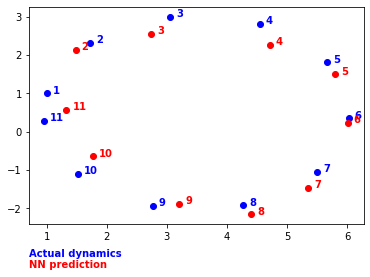

In [48]:
initial_state = np.array([[1.0, 1.0, 0.5]])
plotActualDynamicsAndNNPredictions(initial_state)

#### 6.2) For $x_0 = [5.0, 8.0, 1.5]$

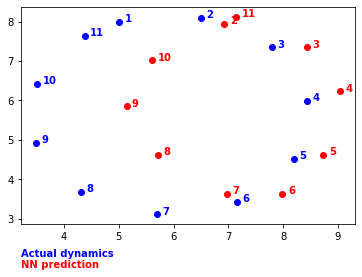

In [50]:
initial_state = np.array([[5.0, 8.0, 1.5]])
plotActualDynamicsAndNNPredictions(initial_state)

<span style="color: #8080ff">**QUESTION 6**: </span> Why does the NN predictions seem better for $x_0 = [1.0, 1.0, 0.5]$ compared with $x_0 = [5.0, 8.0, 1.5]$? (*Hint:* take a look at the file *dataset_generation.ipynb* to see how the trajectories are created for the dataset. More specifically, note in which region of $\mathbb{R}^3$ the model is being trained on).

### 7) **Your task**: Building a larger and more accurate NN

After seeing the previous example, we now have the goal of building a larger and more accurate NN. For this, we propose the changes below (but feel free to test other possibilities). Also, we ask a few more questions to guide your understanding of the training.

**NN structure**:

- Add one or two new hidden layers, varying the number of neurons per hidden layer. OBS: There are some discussions on the literature about *depth vs width* of neural networks.

- Test other types of activation functions (other than ReLU). <span style="color: #8080ff">**QUESTION 7** </span>: What are the advantages of using ReLU when compared to other activation functions?

**Training parameters**:

- Increase the number of epochs; change the batch size

- Test other types of optimizers (e.g. RMSprop, Adagrad, ...)

- Add regularization to the loss function

- <span style="color: #8080ff">**QUESTION 8**: </span>Are there other loss functions that could make sense for this problem?


**You only need to report your final choices, no need to show all the possibilities that you tested**. Try to get a better accuracy on the test set than we had with our small network. 

In [ ]:
#ADD CODE HERE FOR SECTION 7

### 8) [Optional] **Your task**: Building a residual neural network

Build and train a residual neural network (https://en.wikipedia.org/wiki/Residual_neural_network#:~:text=A%20residual%20neural%20network%20(also,reference%20to%20the%20layer%20inputs.) - the exact structure is at your discretion - and explain why this model may potentially work well for the Dubins car. The goal of this section is to present another type of NN structure, as well as allow you to explore the Pytorch framework.

In [ ]:
#ADD CODE HERE FOR SECTION 8

### Appendix: More reading

In this exercise, we used neural networks for system identification in a very simplistic way. If you want to know how those techniques are employed in practice, you can refer to this nice survey "Deep networks for system identification: a survey" (https://arxiv.org/pdf/2301.12832) - especially Section 7 (Applications).

Neural networks are also used in other control applications, e.g.: "Safety Certification for Stochastic Systems via Neural Barrier Functions" (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9990576) discusses about Neural Barrier Functions. [In construction]